In [6]:
!pip install --upgrade pip
!pip install nlpaug
!pip install torchsummary
!pip install datasets
!pip install matplotlib seaborn pandas
!pip install evaluate rouge-score sacrebleu

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


# Import Library

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import csv
import re
import torch
from sklearn.model_selection import train_test_split
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments,DataCollatorWithPadding, DataCollatorForLanguageModeling
from transformers.trainer_callback import TrainerCallback
from torch.utils.data import DataLoader, Dataset, Subset
import evaluate
from transformers import default_data_collator
from transformers import TextDataset, TextDatasetForNextSentencePrediction
import os
from datasets import load_dataset, DatasetDict
from collections import defaultdict

# Cleaning Data

In [12]:
os.environ["WANDB_DISABLED"] = "true"
# Load Data
df = pd.read_csv('/kaggle/input/layoutlm/medquad.csv')

# Sample Data
print("Data Sample")
print(df.head())

# Check for Null Values
print("Null Value Data")
print(df.isnull().sum())

# List of question words
question_words = ['what', 'who', 'why', 'when', 'where', 'how', 'is', 'are', 'does', 'do', 'can', 'will', 'shall']

# Ensure questions are lowercase for consistent filtering
df['question'] = df['question'].str.lower()

# Filter rows where the question starts with a question word
df = df[df['question'].str.split().str[0].isin(question_words)]

# Reset index after filtering
df = df.reset_index(drop=True)

# Check for duplicate rows
duplicates = df.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

# Remove duplicate rows
df = df.drop_duplicates()

# Reset the index after removing duplicates
df.reset_index(drop=True, inplace=True)

# Delete unused columns
df = df.drop(columns=['source', 'focus_area'])

# Table Info
print("Table Info")
print(df.info())

# Drop duplicates in 'question' and 'answer'
df = df.drop_duplicates(subset='question', keep='first').reset_index(drop=True)
df = df.drop_duplicates(subset='answer', keep='first').reset_index(drop=True)

# Drop rows with null values in 'question' and 'answer'
df = df.drop_duplicates(subset=['question', 'answer']).reset_index(drop=True)
df['question'] = df['question'].fillna('').astype(str)
df['answer'] = df['answer'].fillna('').astype(str)

# Clean the text by removing content in parentheses and extra spaces
def clean_text(text):
    text = re.sub(r"\(.*?\)", "", text)  # Remove content inside parentheses
    text = re.sub(r'\s+', ' ', text.strip().lower())  # Remove extra spaces and lowercase text
    return text

df['question'] = df['question'].apply(clean_text)
df['answer'] = df['answer'].apply(clean_text)

# Merge 'question' and 'answer' into 'prompt'
df['prompt'] = df['question'] + ' ' + df['answer']

# Clean extra spaces again after combining
df['question'] = df['question'].str.lower().str.strip().apply(lambda x: re.sub(r'\s+', ' ', x))
df['answer'] = df['answer'].str.lower().str.strip().apply(lambda x: re.sub(r'\s+', ' ', x))

# Checking again for null values
print("Null Value Data")
print(df.isnull().sum())

# Check for unique data
print(f"Unique questions: {df['question'].nunique()}")
print(f"Unique answers: {df['answer'].nunique()}")

# Checking again for the data info
df.info()

# Truncate the dataset to a much smaller portion (e.g., 10% of the original data)
df = df.sample(frac=0.6, random_state=42)

# Check the truncated dataset
print("Truncated Data")
print(df.head())


Data Sample
                                 question  \
0                What is (are) Glaucoma ?   
1                  What causes Glaucoma ?   
2     What are the symptoms of Glaucoma ?   
3  What are the treatments for Glaucoma ?   
4                What is (are) Glaucoma ?   

                                              answer           source  \
0  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   
1  Nearly 2.7 million people have glaucoma, a lea...  NIHSeniorHealth   
2  Symptoms of Glaucoma  Glaucoma can develop in ...  NIHSeniorHealth   
3  Although open-angle glaucoma cannot be cured, ...  NIHSeniorHealth   
4  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   

  focus_area  
0   Glaucoma  
1   Glaucoma  
2   Glaucoma  
3   Glaucoma  
4   Glaucoma  
Null Value Data
question       0
answer         5
source         0
focus_area    14
dtype: int64
Number of duplicate rows: 48
Table Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1

# Architecting Model

In [13]:
# Assuming df is your DataFrame and contains a 'prompt' column
print("Column names in the DataFrame:", df.columns)

# Split data into training and validation sets
train_data, val_data = train_test_split(df['prompt'], test_size=0.1, random_state=42)

# Save the train and validation data to text files
train_data.to_csv('/kaggle/working/train.txt', index=False, header=False)
val_data.to_csv('/kaggle/working/val.txt', index=False, header=False)

# Load pre-trained GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

model = GPT2LMHeadModel.from_pretrained('gpt2')
def summarize_model_by_type(model):
    layer_summary = defaultdict(int)
    param_summary = defaultdict(int)

    for name, module in model.named_modules():
        layer_type = type(module).__name__
        layer_summary[layer_type] += 1
        param_summary[layer_type] += sum(p.numel() for p in module.parameters())

    print(f"{'Layer Type':<30}{'Count':<10}{'Parameters':<15}")
    print("=" * 55)
    for layer_type, count in layer_summary.items():
        print(f"{layer_type:<30}{count:<10}{param_summary[layer_type]:<15,}")

summarize_model_by_type(model)
# Load dataset
dataset = load_dataset('text', data_files={'train': '/kaggle/working/train.txt', 'validation': '/kaggle/working/val.txt'})

# Tokenize datasets
def tokenize_function(examples):
    tokenized_inputs = tokenizer(
        examples['text'], truncation=True, padding="max_length", max_length=128
    )
    tokenized_inputs["labels"] = tokenized_inputs["input_ids"].copy()
    return tokenized_inputs

tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["text"])
train_dataset = tokenized_datasets['train']
val_dataset = tokenized_datasets['validation']

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Training arguments
training_args = TrainingArguments(
    output_dir='/kaggle/working/chatbot_model',
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    logging_steps=100,
    evaluation_strategy="steps",
    save_steps=500,
    prediction_loss_only=False,
    load_best_model_at_end=True,
    logging_dir='./logs',
)

# Metrics
rouge_metric = evaluate.load("rouge")
bleu_metric = evaluate.load("bleu")

import numpy as np

# Function to compute ROUGE and BLEU metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Apply softmax to the logits to get probabilities
    predictions = np.exp(predictions) / np.sum(np.exp(predictions), axis=-1, keepdims=True)
    
    # Get the most probable token for each sequence
    predicted_ids = np.argmax(predictions, axis=-1)

    # Decode predictions and labels
    decoded_preds = tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Normalize text
    def normalize_text(texts):
        return [" ".join(str(text).lower().strip().split()) for text in texts]

    normalized_preds = normalize_text(decoded_preds)
    normalized_labels = normalize_text(decoded_labels)

    # Prepare references for BLEU and ROUGE
    references = [[label] for label in normalized_labels]
    
    # Compute ROUGE and BLEU metrics
    try:
        rouge_results = rouge_metric.compute(predictions=normalized_preds, references=references)
        rouge1_fmeasure = rouge_results.get('rouge1', {}).get('fmeasure', 0.0)  
        return {
            'rouge1_fmeasure': rouge1_fmeasure,
        }
    except Exception as e:
        print(f"Error in compute_metrics: {e}")
        return {'rouge1_fmeasure': 0.0, 'bleu': 0.0}

# Logging callback
from transformers import TrainerCallback

class ImprovedLoggingCallback(TrainerCallback):
    def __init__(self, trainer, val_dataset, tokenizer, output_file='/kaggle/working/log_metrics.csv'):
        self.trainer = trainer
        self.val_dataset = val_dataset
        self.tokenizer = tokenizer
        self.output_file = output_file
        # Create or overwrite the output CSV file and write the header
        with open(self.output_file, mode="w", newline="") as file:
            writer = csv.writer(file)
            writer.writerow(["step", "rouge1_fmeasure"])

    def on_log(self, args, state, control, logs=None, **kwargs):
        if state.global_step % args.logging_steps == 0 and state.global_step > 0:
            print(f"Step {state.global_step}: Logging metrics...")
    
            # Use a small subset of validation data for evaluation
            subset_indices = list(range(min(len(self.val_dataset), 100)))
            small_eval_dataset = Subset(self.val_dataset, subset_indices)
    
            predictions_output = self.trainer.predict(small_eval_dataset)  # Use the trainer instance
            predictions = predictions_output.predictions
            labels = predictions_output.label_ids
    
            if isinstance(predictions, torch.Tensor):
                predictions = predictions.detach().cpu().numpy() 
    
            # Get the token with the highest probability for each token in the sequence
            predicted_ids = np.argmax(predictions, axis=-1)
    
            # Decode predictions and labels
            decoded_preds = self.tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)
            decoded_labels = self.tokenizer.batch_decode(labels, skip_special_tokens=True)
    
            # Normalize text function
            def normalize_text(texts):
                return [" ".join(str(text).lower().strip().split()) for text in texts]
            normalized_preds = normalize_text(decoded_preds)
            normalized_labels = normalize_text(decoded_labels)
            # Prepare references for ROUGE
            references = [[label] for label in normalized_labels]    
            # Compute ROUGE metrics
            try:
                rouge_results = rouge_metric.compute(predictions=normalized_preds, references=references)
                print("ROUGE:", rouge_results)
                print(rouge_results['rouge1'])
                # Log metrics
                metrics = {
                    "rouge1_fmeasure": rouge_results['rouge1'],
                    "step": state.global_step
                }
                # Log to CSV
                with open(self.output_file, mode="a", newline="") as file:
                    writer = csv.writer(file)
                    writer.writerow([
                        metrics["step"], 
                        metrics["rouge1_fmeasure"],
                    ])
    
                print("Metrics logged:", metrics)
    
            except Exception as e:
                print(f"Error in computing ROUGE metrics: {e}")
    
# Initialize trainer first
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=None,
)

# Initialize the logging callback with all required arguments
logging_callback = ImprovedLoggingCallback(trainer=trainer, val_dataset=val_dataset, tokenizer=tokenizer)

# Add the callback to the trainer
trainer.add_callback(logging_callback)

# Train the model
trainer.train()

# Save the model and tokenizer
model.save_pretrained('/kaggle/working/chatbot_model')
tokenizer.save_pretrained('/kaggle/working/chatbot_model')
log_history = trainer.state.log_history
print("Model and tokenizer saved successfully.")


Column names in the DataFrame: Index(['question', 'answer', 'prompt'], dtype='object')


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Layer Type                    Count     Parameters     
GPT2LMHeadModel               1         124,439,808    
GPT2Model                     1         124,439,808    
Embedding                     2         39,383,808     
Dropout                       37        0              
ModuleList                    1         85,054,464     
GPT2Block                     12        85,054,464     
LayerNorm                     25        38,400         
GPT2SdpaAttention             12        28,348,416     
Conv1D                        48        85,017,600     
GPT2MLP                       12        56,669,184     
NewGELUActivation             12        0              
Linear                        1         38,597,376     


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/7483 [00:00<?, ? examples/s]

Map:   0%|          | 0/832 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss,Validation Loss
100,2.329800,1.900918
200,1.938100,1.800187
300,1.914200,1.744080
400,1.845200,1.705080
500,1.735100,1.675189
600,1.746200,1.650839
700,1.715400,1.631217
800,1.692000,1.616957
900,1.695500,1.601877
1000,1.642200,1.595727


Step 100: Logging metrics...
ROUGE: {'rouge1': 0.607038979917161, 'rouge2': 0.34548298240586356, 'rougeL': 0.5330023052093256, 'rougeLsum': 0.5338193287865152}
0.607038979917161
Metrics logged: {'rouge1_fmeasure': 0.607038979917161, 'step': 100}
Step 100: Logging metrics...
ROUGE: {'rouge1': 0.607038979917161, 'rouge2': 0.34548298240586356, 'rougeL': 0.5330023052093256, 'rougeLsum': 0.5338193287865152}
0.607038979917161
Metrics logged: {'rouge1_fmeasure': 0.607038979917161, 'step': 100}
Step 200: Logging metrics...
ROUGE: {'rouge1': 0.6232632513715584, 'rouge2': 0.36822004073987724, 'rougeL': 0.5554273577044722, 'rougeLsum': 0.5557648760706152}
0.6232632513715584
Metrics logged: {'rouge1_fmeasure': 0.6232632513715584, 'step': 200}
Step 200: Logging metrics...
ROUGE: {'rouge1': 0.6232632513715584, 'rouge2': 0.36822004073987724, 'rougeL': 0.5554273577044722, 'rougeLsum': 0.5557648760706152}
0.6232632513715584
Metrics logged: {'rouge1_fmeasure': 0.6232632513715584, 'step': 200}
Step 300: 

There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Model and tokenizer saved successfully.


# Show Graphic 

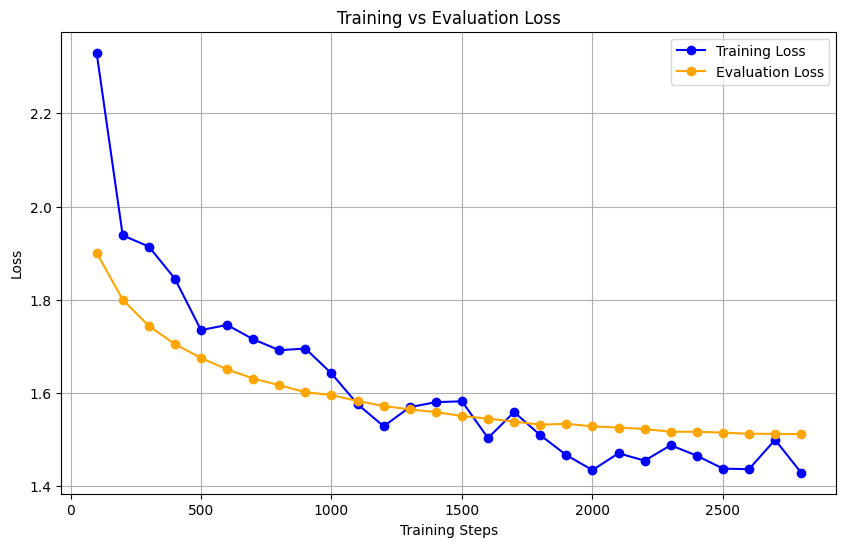

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


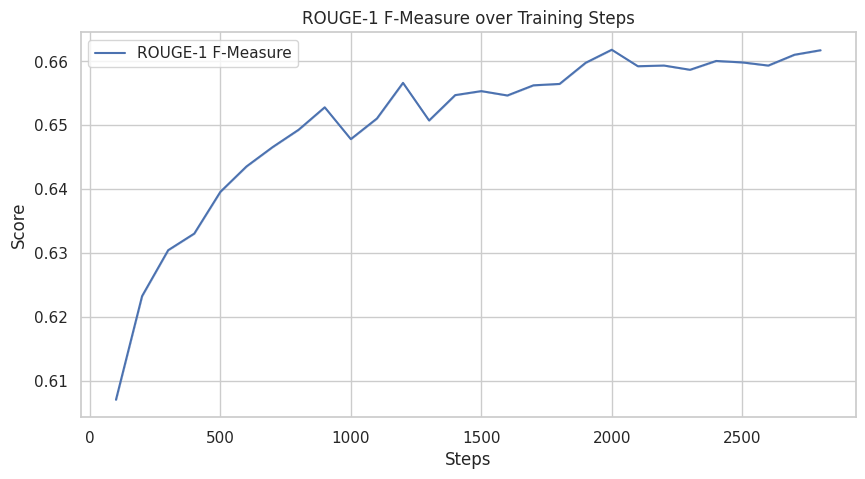

In [14]:
train_loss = []
eval_loss = []
steps = []
eval_steps = []
for log in log_history:
    if "loss" in log:
        train_loss.append(log["loss"])
        steps.append(log["step"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
        eval_steps.append(log["step"])
plt.figure(figsize=(10, 6))
plt.plot(steps, train_loss, label="Training Loss", color="blue", marker="o")
plt.plot(steps[:len(eval_loss)], eval_loss, label="Evaluation Loss", color="orange", marker="o")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training vs Evaluation Loss")
plt.legend()
plt.grid(True)
plt.show()
# Load the metrics_logs.csv file
metrics_df = pd.read_csv('/kaggle/working/log_metrics.csv')

# Set the style of the plots
sns.set(style="whitegrid")

# Create a line plot for rouge1_fmeasure
plt.figure(figsize=(10, 5))
sns.lineplot(x='step', y='rouge1_fmeasure', data=metrics_df, label='ROUGE-1 F-Measure')
plt.xlabel('Steps')
plt.ylabel('Score')
plt.title('ROUGE-1 F-Measure over Training Steps')
plt.legend()
plt.show()


# Testing Using Inputs

In [16]:
# Load the fine-tuned model and tokenizer
model = GPT2LMHeadModel.from_pretrained('/kaggle/working/chatbot_model')
tokenizer = GPT2Tokenizer.from_pretrained('/kaggle/working/chatbot_model')

# Function to generate chatbot response
def generate_response(prompt):
    inputs = tokenizer.encode(prompt, return_tensors="pt")
    outputs = model.generate(inputs, max_length=150, num_return_sequences=1, no_repeat_ngram_size=2, temperature=0.7)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

# Example usage
prompt = "what is mental illness?"
response = generate_response(prompt)
print(response)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


what is mental illness? mental illnesses are mental disorders that affect many parts of the body. they include - anxiety - depression - obsessive compulsive disorder - trouble sleeping - loss of control of body movements - seizures - dementia - mental retardation - schizophrenia - personality disorders - stroke - substance abuse - alcohol abuse, and suicide - certain types of mental health disorders can affect people differently. some mental diseases are more common in people with no history of any mental disorder in their family. other mental conditions can be more severe. for example, people who have a history or history with a mental disease may have more than one mental condition. these disorders may be caused by changes in the genes or by other factors. treatment is based on the signs and symptoms present in each
